In [1]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001


train_dataset = dsets.MNIST(root='./data/',
                               train=True, 
                               download=True)

test_dataset = dsets.MNIST(root='./data/',
                              train=False, 
                              download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [18]:
class DNN:
    def __init__(self, sizes, epochs, lr):
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr

        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

#         self.params = {
#             'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
#             'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
#             'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
#         }

        self.params = pickle.load(open('weights2.pkl','rb'))
    def relu(self, x, derivative=False):
        if derivative:
            return np.heaviside(x, 0) 
        return max(0.0, x)
        
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)
    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
#         print(f'W1 SHAPE: {params["W1"].shape}')
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters.

          Note: There is a stability issue that causes warnings. This is 
                caused  by the dot and multiply operations on the huge arrays.

                RuntimeWarning: invalid value encountered in true_divide
                RuntimeWarning: overflow encountered in exp
                RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.

          θ = θ - η * ∇J(x, y), 
              theta θ:            a network parameter (e.g. a weight w)
              eta η:              the learning rate
              gradient ∇J(x, y):  the gradient of the objective function,
                                  i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.lr * value

    def compute_accuracy(self, test_data, output_nodes):
        '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x in test_data:
#                 all_values = x.split(',')
            # scale and shift the inputs
            X_test, y_test = x
            inputs = (np.asfarray(X_test) / 255.0 * 0.99) + 0.01
            # create the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            # all_values[0] is the target label for this record
            targets[int(y_test)] = 0.99
            output = self.forward_pass(np.array(inputs).flatten())
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(targets))

        return np.mean(predictions)

    def train(self, train_list, test_list, output_nodes):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x in train_list:
                X_train, y_train = x
#                 all_values = x.split(',')
                # scale and shift the inputs
                inputs = (np.asfarray(X_train) / 255.0 * 0.99) + 0.01
                # create the target output values (all 0.01, except the desired label which is 0.99)
                targets = np.zeros(output_nodes) + 0.01
                # all_values[0] is the target label for this record
                targets[int(y_train)] = 0.99
#                 print(f'inputs SHAPE: {inputs.shape}')
                output = self.forward_pass(np.array(inputs).flatten())
                changes_to_w = self.backward_pass(targets, output)
                self.update_network_parameters(changes_to_w)
          
            accuracy = self.compute_accuracy(test_list, output_nodes)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(iteration+1, time.time() - start_time, accuracy * 100
    ))

In [19]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=20, lr=0.001)
dnn.train(train_dataset, test_dataset, 10)

Epoch: 1, Time Spent: 93.40s, Accuracy: 72.24%
Epoch: 2, Time Spent: 186.94s, Accuracy: 72.86%
Epoch: 3, Time Spent: 280.46s, Accuracy: 73.35%
Epoch: 4, Time Spent: 374.55s, Accuracy: 73.81%
Epoch: 5, Time Spent: 467.46s, Accuracy: 74.36%
Epoch: 6, Time Spent: 561.14s, Accuracy: 74.81%
Epoch: 7, Time Spent: 654.37s, Accuracy: 75.14%
Epoch: 8, Time Spent: 748.08s, Accuracy: 75.46%
Epoch: 9, Time Spent: 841.49s, Accuracy: 75.70%
Epoch: 10, Time Spent: 2004.79s, Accuracy: 75.96%
Epoch: 11, Time Spent: 2090.09s, Accuracy: 76.19%
Epoch: 12, Time Spent: 2193.85s, Accuracy: 76.38%
Epoch: 13, Time Spent: 2301.37s, Accuracy: 76.65%
Epoch: 14, Time Spent: 2404.95s, Accuracy: 76.91%
Epoch: 15, Time Spent: 2517.73s, Accuracy: 77.18%
Epoch: 16, Time Spent: 2620.15s, Accuracy: 77.35%
Epoch: 17, Time Spent: 2716.52s, Accuracy: 77.55%
Epoch: 18, Time Spent: 2817.59s, Accuracy: 77.73%
Epoch: 19, Time Spent: 2922.71s, Accuracy: 77.87%
Epoch: 20, Time Spent: 3028.34s, Accuracy: 78.07%


In [11]:
import pickle
pickle.dump(dnn.params,open('weights.pkl','wb'))

In [12]:
weights = pickle.load(open('weights.pkl','rb'))

In [13]:
weights

{'W1': array([[ 0.11050382,  0.08023619, -0.04264737, ..., -0.02441014,
          0.14349291, -0.11566268],
        [ 0.04966209, -0.0113086 , -0.10062325, ...,  0.06744061,
          0.09695635,  0.1190933 ],
        [-0.07069712,  0.0116214 , -0.0418254 , ...,  0.11330652,
         -0.15679504, -0.05353369],
        ...,
        [-0.02941993, -0.09389072,  0.01387301, ...,  0.01281192,
         -0.02529847,  0.02543002],
        [ 0.05944651, -0.06666962, -0.13277605, ...,  0.06407712,
         -0.01224771, -0.08340747],
        [ 0.21673636, -0.05373604,  0.11072705, ..., -0.00630943,
          0.01415059,  0.02065931]]),
 'W2': array([[ 0.08583197,  0.12001696,  0.01976871, ..., -0.19375589,
          0.16368216,  0.0725653 ],
        [ 0.03519567,  0.10748514,  0.02181508, ...,  0.15229214,
         -0.12478883, -0.05856825],
        [ 0.01562512,  0.10800901,  0.29490405, ...,  0.05659677,
         -0.01824732,  0.16522978],
        ...,
        [-0.01832315, -0.15836459, -0.1482

In [17]:
pickle.dump(dnn.params,open('weights2.pkl','wb'))
weights2 = pickle.load(open('weights2.pkl','rb'))

In [20]:
weights2

{'W1': array([[ 0.1105388 ,  0.08027118, -0.04261238, ..., -0.02437516,
          0.14352789, -0.1156277 ],
        [ 0.04979032, -0.01118038, -0.10049503, ...,  0.06756884,
          0.09708458,  0.11922153],
        [-0.07061054,  0.01170798, -0.04173882, ...,  0.11339311,
         -0.15670846, -0.0534471 ],
        ...,
        [-0.02953773, -0.09400853,  0.0137552 , ...,  0.01269411,
         -0.02541627,  0.02531221],
        [ 0.05945433, -0.06666179, -0.13276823, ...,  0.06408494,
         -0.01223988, -0.08339964],
        [ 0.2167942 , -0.0536782 ,  0.11078488, ..., -0.0062516 ,
          0.01420842,  0.02071715]]),
 'W2': array([[ 0.10236543,  0.13307139,  0.03567488, ..., -0.17294779,
          0.17645263,  0.09137546],
        [ 0.03124794,  0.08683179,  0.03224896, ...,  0.21609987,
         -0.11168422, -0.1021773 ],
        [ 0.03044996,  0.11954315,  0.30868132, ...,  0.07453653,
         -0.00511438,  0.18142674],
        ...,
        [-0.01630547, -0.1289105 , -0.1864

In [21]:
pickle.dump(dnn.params,open('weights3.pkl','wb'))
weights3 = pickle.load(open('weights3.pkl','rb'))

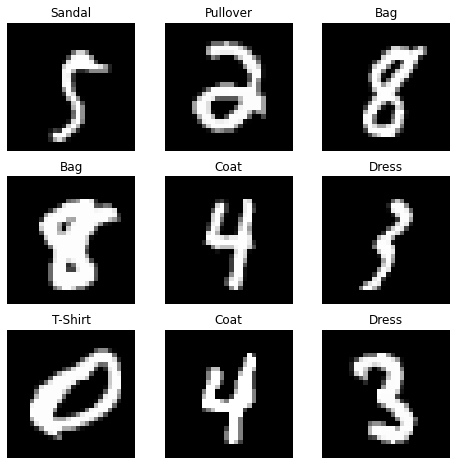

In [21]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [23]:
torch.randint(len(train_dataset), size=(1,)).item()

38701

In [76]:
x, y = train_dataset[0]

In [107]:
np.array(x).flatten()

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [61]:
y

5

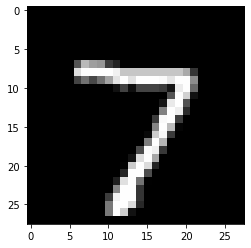

In [44]:
plt.imshow(x, cmap='gray')

In [7]:
def reluDerivative(x):
    return np.heaviside(x, 0)

In [9]:
print(reluDerivative(-6))

0.0
